[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [2]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Clear Data

## Check for Null

### since the data is synthetic there are no null values
#### (as shown bellow)

In [ ]:
df.isnull().sum()

## Understand The Data & Trends

### Transaction Types

In [ ]:
df['type'].value_counts().plot.bar()
plt.show()

In [ ]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

### Fraud happens aroud 0.13%

In [ ]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [ ]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

### Precentage of Transfer Fraud is about 0.77%

In [ ]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

### Precentage of Cash Out Fraud is about 0.18%

In [ ]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [ ]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [ ]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

### Clients who Commited Fraud also Have Legit Transactions

In [ ]:
fraudClients = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudClients[0]].head()

### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [ ]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [ ]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [ ]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

---
# Predict Fraud

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# from sklearn.tree import DecisionTreeClassifier

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Convert Strings to float/int

In [6]:
#tmp
df2 = df.copy()

In [7]:
df = df2

In [8]:
data = df.copy()

In [9]:
# REMOVE NO FRAUD TYPE
d1 = data[data['type']=='TRANSFER']
d2 = data[data['type']=='CASH_OUT']
data = pd.concat([d1, d2])

In [10]:
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
2,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,0,1
19,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0,1
24,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0,1
58,1,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,0,1
78,1,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,0,1


2            1
251          1
680          1
969          1
1115         1
          ... 
6362611    742
6362613    743
6362615    743
6362617    743
6362619    743
Name: step, Length: 8213, dtype: int64

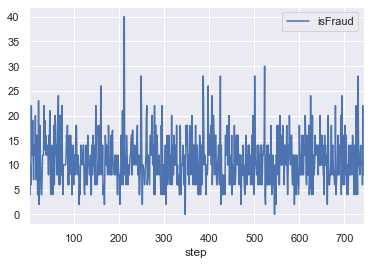

In [11]:
## FIND DAYS WITH NO FRAUD
tmp = data[['step', 'isFraud']]
tmp.groupby(['step']).sum().plot()
daysNoFraud = data[data['isFraud']==0]['step']
daysWithFraud = data[data['isFraud']==1]['step']
# daysWithFraud

# data[[False if x in daysWithFraud else True for x in daysNoFraud]]
# for i in range(744):
#     if i not in daysWithFraud:
#         print(i)
daysWithFraud
# 1 in [1]

In [ ]:
#change step to day
tmp = data[['step', 'isFraud']]
tmp['step'] = tmp['step']//24+1
tmp.groupby(['step']).sum().plot()

In [ ]:
#change step to times of day 0-23
tmp = data[['step', 'isFraud']]
tmp['step'] = tmp['step']%24
tmp.groupby(['step']).sum().plot()

In [ ]:
tmp = pd.get_dummies(data['step'])
data = data.join(tmp)
data = data.drop('step', axis=1)
data.head()

In [12]:
data = data.drop(['nameOrig', 'nameDest', 'step'], axis=1)
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
2,181.00,181.00,0.0,0.00,0.00,1,0,0,1
19,215310.30,705.00,0.0,22425.00,0.00,0,0,0,1
24,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,0,1
58,62610.80,79114.00,16503.2,517.00,8383.29,0,0,0,1
78,42712.39,10363.39,0.0,57901.66,24044.18,0,0,0,1


In [13]:
def normalize(x):
    data[x] = data[x]/data[x].max()
    
[normalize(x) for x in data]
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
2,0.000002,0.000003,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0
19,0.002329,0.000012,0.000000,0.000063,0.000000,0.0,0.0,0.0,1.0
24,0.003372,0.000182,0.000000,0.000018,0.007634,0.0,0.0,0.0,1.0
58,0.000677,0.001328,0.000333,0.000001,0.000024,0.0,0.0,0.0,1.0
78,0.000462,0.000174,0.000000,0.000163,0.000068,0.0,0.0,0.0,1.0


In [14]:
dddd = data.copy()

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # data = [[0, 0], [0, 0], [1, 1], [1, 1]]
# scaler = StandardScaler()
# print(scaler.fit(data))
# StandardScaler()
# print(scaler.mean_)
# print(scaler.transform(data))
# scale = scaler.transform(data)
# print(scale[0])
# data.head()
# print(scaler.transform([[2, 2]]))

In [15]:
X=data.drop('isFraud', axis=1)
y=data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train

In [16]:
def evaluate(test, prediction):
    print(classification_report(y_test,predictions))
    print(confusion_matrix(test, prediction))
    print(metrics.accuracy_score(test, prediction))

### Logistic Regression

In [17]:
lr=LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(X_train,y_train)
predictions=lr.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.97      0.09      0.17      2488

    accuracy                           1.00    831123
   macro avg       0.98      0.55      0.58    831123
weighted avg       1.00      1.00      1.00    831123

[[828627      8]
 [  2263    225]]
0.9972675524561346


### Linear SVC

In [ ]:
clf = LinearSVC(random_state=0, tol=1e30)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
clf = LinearSVC(random_state=0, tol=9*1e-1)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
clf = LinearSVC(random_state=0, tol=1e-2)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
clf = LinearSVC(random_state=0, tol=1e-3)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

### RandomForestClassifier

In [27]:
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09578667 0.17368984 0.12777803 0.18414116 0.21746959 0.
 0.09595532 0.10517939]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       1.00      0.01      0.02      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.50      0.51    831123
weighted avg       1.00      1.00      1.00    831123

[[828635      0]
 [  2469     19]]
0.9970293205698796


In [28]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.20750841 0.31706472 0.09407142 0.10859149 0.13325425 0.
 0.0915973  0.04791242]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       1.00      0.10      0.17      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.55      0.59    831123
weighted avg       1.00      1.00      1.00    831123

[[828635      0]
 [  2250    238]]
0.9972928194743739


In [29]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[1.34524599e-01 1.84816170e-01 1.04300148e-01 9.33626490e-02
 3.84685895e-01 8.76313259e-05 7.18789219e-02 2.63439851e-02]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       1.00      0.29      0.46      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.65      0.73    831123
weighted avg       1.00      1.00      1.00    831123

[[828635      0]
 [  1755    733]]
0.9978883991900116


In [30]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.21420586 0.22368526 0.08064528 0.05642741 0.27896333 0.00522283
 0.02104483 0.11980521]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       1.00      0.27      0.43      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.64      0.71    831123
weighted avg       1.00      1.00      1.00    831123

[[828635      0]
 [  1814    674]]
0.997817410900673


In [31]:
clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.14368348 0.35376245 0.05356609 0.05419555 0.33310051 0.00332259
 0.00875363 0.0496157 ]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       1.00      0.50      0.67      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.75      0.83    831123
weighted avg       1.00      1.00      1.00    831123

[[828634      1]
 [  1244   1244]]
0.9985020267758202


In [32]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.18159578 0.32353809 0.05043189 0.07305648 0.3171351  0.00139656
 0.03527324 0.01757287]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.99      0.69      0.82      2488

    accuracy                           1.00    831123
   macro avg       1.00      0.85      0.91    831123
weighted avg       1.00      1.00      1.00    831123

[[828626      9]
 [   768   1720]]
0.9990651203251504


In [33]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.1779815  0.25010953 0.0682028  0.07191186 0.36216578 0.00071331
 0.0306774  0.03823782]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.99      0.73      0.84      2488

    accuracy                           1.00    831123
   macro avg       0.99      0.87      0.92    831123
weighted avg       1.00      1.00      1.00    831123

[[828611     24]
 [   665   1823]]
0.999171001163486


In [34]:
clf = RandomForestClassifier(max_depth=30, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.19211294 0.32645443 0.04709776 0.0873201  0.32283389 0.00061088
 0.01296924 0.01060077]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.98      0.75      0.85      2488

    accuracy                           1.00    831123
   macro avg       0.99      0.87      0.92    831123
weighted avg       1.00      1.00      1.00    831123

[[828592     43]
 [   624   1864]]
0.9991974713730699


In [35]:
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.20602376 0.31274488 0.04638764 0.09314559 0.31567489 0.00052845
 0.0137574  0.01173738]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.98      0.75      0.85      2488

    accuracy                           1.00    831123
   macro avg       0.99      0.88      0.92    831123
weighted avg       1.00      1.00      1.00    831123

[[828588     47]
 [   615   1873]]
0.9992034873297936


In [36]:
clf = RandomForestClassifier(max_depth=200, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.20602376 0.31274488 0.04638764 0.09314559 0.31567489 0.00052845
 0.0137574  0.01173738]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    828635
         1.0       0.98      0.75      0.85      2488

    accuracy                           1.00    831123
   macro avg       0.99      0.88      0.92    831123
weighted avg       1.00      1.00      1.00    831123

[[828588     47]
 [   615   1873]]
0.9992034873297936


### KNN

In [ ]:
#knn - predictions are made 
k=KNeighborsClassifier(n_neighbors=1)
k.fit(X_train,y_train)
#now we have train the model

predictions=k.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
#now lets find the optimum K 
err_rate = []
for i in range(1,30):
    k = KNeighborsClassifier(n_neighbors=i)
    k.fit(X_train, y_train)
    pred_i=k.predict(X_test)
    
    err_rate.append(np.mean(pred_i !=y_test))